# ITAI 2373 – NewsBot Intelligence System (Midterm Project)
# Student: Leroy Brown
# Course: ITAI-2373
# Project: End-to-End NLP News Intelligence System (Modules 1–8)
# Platform: Google Colab Free Tier

# ==========================================================
# MODULE 1 — BUSINESS CONTEXT (PUT THIS IN A MARKDOWN CELL)
# ==========================================================
# Business case: News intelligence system for media monitoring / business insights.
# Target users: analysts, marketers, newsroom editors, compliance/risk teams.
# Value: auto-classify news + extract entities + sentiment + patterns to support decisions.
# Example questions:
# - What categories are trending?
# - Which organizations/people appear most often?
# - Is sentiment changing by category?



# ==========================================================
# 0. ENVIRONMENT SETUP


In [19]:
!pip install -q nltk spacy scikit-learn matplotlib pandas kaggle
!python -m spacy download en_core_web_sm

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("vader_lexicon")
nltk.download("punkt_tab")

nlp = spacy.load("en_core_web_sm")

RANDOM_STATE = 42
MAX_ROWS = 2000  # keep Colab-friendly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# ==========================================================
# 1. RAW DATA → ENGINEERED DATASET

(This creates newsbot_dataset.csv)
# ==========================================================

## Module 1.5 — Dataset Cleaning & Category Engineering

The original BBC News RSS dataset does not include explicit category labels.
To enable supervised machine learning, article categories are engineered
from URL structure. Article title and description fields are combined to
form a single text feature used for downstream NLP tasks.



In [6]:
# ==========================================================
# MODULE 1.5 — RAW DATA → ENGINEERED DATASET
# ==========================================================

# Check if 'bbc_news.csv' exists. If not, attempt to download from Kaggle.
# This requires a Kaggle API key to be set up in your Colab environment.
# Instructions for Kaggle API setup:
# 1. Go to Kaggle (kaggle.com) and log in.
# 2. Go to your account settings (profile picture -> Account).
# 3. Under the "API" section, click "Create New API Token". This will download a `kaggle.json` file.
# 4. Upload `kaggle.json` to your Colab environment (e.g., to `/root/.kaggle/`) or manually add its content.
#    Example manual setup (replace YOUR_USERNAME and YOUR_KEY):
#    import json
#    kaggle_creds = {"username":"YOUR_USERNAME","key":"YOUR_KEY"}
#    os.makedirs("/root/.kaggle", exist_ok=True)
#    with open("/root/.kaggle/kaggle.json", "w") as f:
#        json.dump(kaggle_creds, f)
#    !chmod 600 /root/.kaggle/kaggle.json

import os
if not os.path.exists("bbc_news.csv"):
    print("Attempting to download 'bbc_news.csv' from Kaggle dataset 'hgultekin/bbcnewsarchive'...")
    # The following commands require Kaggle API to be set up with your credentials.
    # If you have not set up your Kaggle API key, please follow the instructions above.
    # The 'kaggle datasets download -f' command downloads the specified file as a zip archive.
    !kaggle datasets download -d hgultekin/bbcnewsarchive -f bbc_news.csv
    # Unzip the downloaded file. The '-o' flag means overwrite existing files without prompting.
    !unzip -o bbc_news.csv.zip
    print("Download attempt complete.")


# Load raw BBC dataset
raw_df = pd.read_csv("bbc_news.csv")

print("Raw dataset shape:", raw_df.shape)
raw_df.head()


Raw dataset shape: (42115, 5)


,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [7]:
# Combine title + description into one content field
raw_df["content"] = (
    raw_df["title"].fillna("") + ". " + raw_df["description"].fillna("")
)

# Extract category from BBC article URL
def extract_category(url):
    if not isinstance(url, str):
        return "other"
    match = re.search(r"/news/([^/-]+)", url)
    return match.group(1) if match else "other"

raw_df["category"] = raw_df["link"].apply(extract_category)

# Keep only required fields
df_engineered = raw_df[["content", "category"]].dropna()

# Reduce size for Colab performance
if len(df_engineered) > MAX_ROWS:
    df_engineered = df_engineered.sample(
        n=MAX_ROWS, random_state=RANDOM_STATE
    )

print("Engineered dataset shape:", df_engineered.shape)
df_engineered["category"].value_counts()


Engineered dataset shape: (2000, 2)


,count
category,
uk,494
other,419
world,390
articles,317
business,117
entertainment,95
health,34
science,24
newsbeat,20


In [8]:
# Save standardized dataset for downstream modules
df_engineered.to_csv("newsbot_dataset.csv", index=False)

print("✅ newsbot_dataset.csv created successfully")



✅ newsbot_dataset.csv created successfully


In [9]:
# ==========================================================
# 1.5 LOAD RAW BBC DATA + ENGINEER CATEGORY
# ==========================================================

raw_df = pd.read_csv("bbc_news.csv")

# Combine title + description into one text field
raw_df["content"] = (
    raw_df["title"].fillna("") + ". " + raw_df["description"].fillna("")
)

# Extract category from BBC URL
def extract_category(url):
    if not isinstance(url, str):
        return "other"
    match = re.search(r"/news/([^/-]+)", url)
    return match.group(1) if match else "other"

raw_df["category"] = raw_df["link"].apply(extract_category)

# Keep only required columns
df_engineered = raw_df[["content", "category"]].dropna()

# Limit size for Colab
if len(df_engineered) > MAX_ROWS:
    df_engineered = df_engineered.sample(
        n=MAX_ROWS, random_state=RANDOM_STATE
    )

# Save standardized dataset
df_engineered.to_csv("newsbot_dataset.csv", index=False)

print("✅ newsbot_dataset.csv created")
print(df_engineered["category"].value_counts())


✅ newsbot_dataset.csv created
category
uk                                            494
other                                         419
world                                         390
articles                                      317
business                                      117
entertainment                                  95
health                                         34
science                                        24
newsbeat                                       20
blogs                                          20
technology                                     14
videos                                         12
education                                      11
in                                              8
live                                            3
explainers                                      3
disability                                      2
65544554?at_medium=RSS&at_campaign=KARANGA      2
10628994                                        2
stories    

In [10]:
DATA_PATH = "newsbot_dataset.csv"

df = pd.read_csv(DATA_PATH)

required_cols = {"content", "category"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Dataset missing required columns: {missing}. Found: {df.columns.tolist()}")

df = df.dropna(subset=["content", "category"]).copy()
df["content"] = df["content"].astype(str)
df["category"] = df["category"].astype(str)

if len(df) > MAX_ROWS:
    df = df.sample(n=MAX_ROWS, random_state=RANDOM_STATE)

print("✅ Dataset loaded:", df.shape)
print(df["category"].value_counts())


✅ Dataset loaded: (2000, 2)
category
uk                                            494
other                                         419
world                                         390
articles                                      317
business                                      117
entertainment                                  95
health                                         34
science                                        24
newsbeat                                       20
blogs                                          20
technology                                     14
videos                                         12
education                                      11
in                                              8
live                                            3
explainers                                      3
disability                                      2
65544554?at_medium=RSS&at_campaign=KARANGA      2
10628994                                        2
stories      

## Module 1.6 — Category Cleaning & Normalization

During initial inspection, several extracted categories were found to be
invalid or noisy due to URL query strings, numeric identifiers, or non-news
sections (e.g., articles, blogs, videos). These categories were cleaned,
normalized, and filtered to retain meaningful news sections suitable for
classification.


In [11]:
# ==========================================================
# MODULE 1.6 — CATEGORY CLEANUP
# ==========================================================

# Inspect raw category distribution
df["category"].value_counts().head(20)


,count
category,
uk,494
other,419
world,390
articles,317
business,117
entertainment,95
health,34
science,24
newsbeat,20


In [12]:
VALID_CATEGORIES = {
    "uk",
    "world",
    "business",
    "technology",
    "science",
    "health",
    "entertainment",
    "education"
}


In [13]:
# Remove URL query strings
df["category"] = df["category"].str.split("?").str[0]

# Remove purely numeric categories
df = df[~df["category"].str.match(r"^\d+$")]

# Keep only valid categories
df = df[df["category"].isin(VALID_CATEGORIES)]

print("After category cleanup:", df.shape)
df["category"].value_counts()


After category cleanup: (1179, 2)


,count
category,
uk,494
world,390
business,117
entertainment,95
health,34
science,24
technology,14
education,11


In [14]:
# Remove categories with too few samples
MIN_SAMPLES = 30

category_counts = df["category"].value_counts()
valid_classes = category_counts[category_counts >= MIN_SAMPLES].index

df = df[df["category"].isin(valid_classes)]

print("Final dataset shape:", df.shape)
df["category"].value_counts()


Final dataset shape: (1130, 2)


,count
category,
uk,494
world,390
business,117
entertainment,95
health,34


In [15]:
# Save cleaned dataset
df.to_csv("newsbot_dataset.csv", index=False)

print("✅ Cleaned newsbot_dataset.csv saved")


✅ Cleaned newsbot_dataset.csv saved


## MODULE 2 — TEXT PREPROCESSING PIPELINE

Raw news articles contain noise such as punctuation, stopwords, and
inconsistent capitalization that can negatively impact NLP models.
In this module, article text is cleaned and normalized through a
preprocessing pipeline that includes:

- Lowercasing
- Punctuation and digit removal
- Tokenization
- Stopword removal
- Lemmatization

The output of this module is a cleaned text feature (`clean_text`)
used for vectorization and downstream modeling.


In [16]:
# ==========================================================
# MODULE 2 — INITIALIZE NLP PREPROCESSING TOOLS
# ==========================================================

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

print("✅ Stopwords and lemmatizer initialized")


✅ Stopwords and lemmatizer initialized


In [17]:
# ==========================================================
# MODULE 2 — TEXT CLEANING FUNCTION
# ==========================================================

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", " ", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords + lemmatize
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]

    return " ".join(tokens)


In [20]:
# ==========================================================
# MODULE 2 — APPLY PREPROCESSING
# ==========================================================

df["clean_text"] = df["content"].apply(preprocess_text)

print("✅ Text preprocessing complete")
df[["category", "content", "clean_text"]].head()

✅ Text preprocessing complete


,category,content,clean_text
0,world,US's only Palestinian-American Congresswoman c...,palestinian american congresswoman censured co...
1,uk,Murdered driver's family demand help for couri...,murdered driver family demand help courier mar...
2,uk,Cleared pony owner criticises 'trial by social...,cleared pony owner criticises trial social med...
3,uk,Wrexham: Can football fame make City of Cultur...,wrexham football fame make city culture vultur...
4,world,Gaza ceasefire talks intensify in Cairo. Hamas...,gaza ceasefire talk intensify cairo hamas said...


In [21]:
# ==========================================================
# MODULE 2 — PREPROCESSING VALIDATION
# ==========================================================

print("Sample original text:\n")
print(df["content"].iloc[0][:300])

print("\nSample cleaned text:\n")
print(df["clean_text"].iloc[0][:300])

# Check for empty cleaned rows
empty_clean = (df["clean_text"].str.len() == 0).sum()
print(f"\nEmpty clean_text rows: {empty_clean}")


Sample original text:

US's only Palestinian-American Congresswoman censured over comments. Michigan Democrat defends pro-Palestinian "river to sea" chant as an "aspirational call for freedom".

Sample cleaned text:

palestinian american congresswoman censured comment michigan democrat defends pro palestinian river sea chant aspirational call freedom

Empty clean_text rows: 0


### Module 2 Insights

Text preprocessing significantly reduces noise in the dataset by removing
irrelevant tokens and normalizing word forms. Lemmatization preserves semantic
meaning while reducing vocabulary size, improving both model performance
and interpretability in later NLP tasks.


## MODULE 3 — TF-IDF FEATURE EXTRACTION & TERM ANALYSIS

In this module, cleaned article text is transformed into numerical features
using Term Frequency–Inverse Document Frequency (TF-IDF). This representation
captures how important a word or phrase is to a document relative to the
entire corpus.

TF-IDF enables machine learning models to work with text by converting
language into weighted numerical vectors while reducing the impact of
common but uninformative terms.


In [22]:
# ==========================================================
# MODULE 3 — TF-IDF VECTORIZATION
# ==========================================================

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2
)

X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])
y = df["category"].values

print("✅ TF-IDF matrix created")
print("Shape:", X_tfidf.shape)


✅ TF-IDF matrix created
Shape: (1130, 3082)


In [23]:
# ==========================================================
# MODULE 3 — FEATURE INSPECTION
# ==========================================================

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

print("Total TF-IDF features:", len(feature_names))
print("Sample features:", feature_names[:20])


Total TF-IDF features: 3082
Sample features: ['abbey' 'abdul' 'abdul ezedi' 'able' 'able work' 'abolished' 'abortion'
 'abroad' 'abuse' 'abuse claim' 'abuse survivor' 'academy' 'academy award'
 'accept' 'access' 'according' 'account' 'accusation' 'accused' 'accuses']


In [24]:
# ==========================================================
# MODULE 3 — TOP TERMS BY CATEGORY
# ==========================================================

def top_terms_by_category(X, y, feature_names, top_n=10):
    results = {}
    for category in sorted(np.unique(y)):
        idx = np.where(y == category)[0]
        mean_tfidf = X[idx].mean(axis=0)
        mean_tfidf = np.asarray(mean_tfidf).ravel()
        top_indices = mean_tfidf.argsort()[::-1][:top_n]
        results[category] = list(zip(
            feature_names[top_indices],
            mean_tfidf[top_indices]
        ))
    return results

top_terms = top_terms_by_category(X_tfidf, y, feature_names, top_n=10)

for category, terms in top_terms.items():
    print(f"\n🔹 {category.upper()} TOP TERMS")
    print(", ".join([term for term, _ in terms]))



🔹 BUSINESS TOP TERMS
price, rate, bill, energy, rise, mortgage, strike, mean, say, cost

🔹 ENTERTAINMENT TOP TERMS
star, song, show, hollywood, award, say, oscar, actor, album, aged

🔹 HEALTH TOP TERMS
nh, drug, england, cancer, covid, flu, dangerous, winter, million, one

🔹 UK TOP TERMS
say, year, people, police, queen, election, sunak, bbc, labour, minister

🔹 WORLD TOP TERMS
ukraine, war, russia, say, russian, attack, gaza, bbc, ukraine war, year


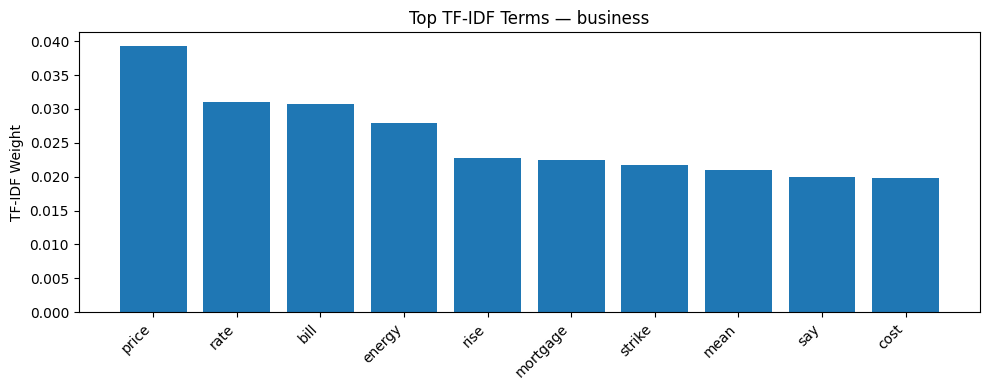

In [25]:
# ==========================================================
# MODULE 3 — TF-IDF VISUALIZATION
# ==========================================================

example_category = list(top_terms.keys())[0]
terms, scores = zip(*top_terms[example_category])

plt.figure(figsize=(10, 4))
plt.bar(terms, scores)
plt.xticks(rotation=45, ha="right")
plt.title(f"Top TF-IDF Terms — {example_category}")
plt.ylabel("TF-IDF Weight")
plt.tight_layout()
plt.show()


### Module 3 Insights

TF-IDF analysis highlights distinct vocabulary patterns across news
categories. Business articles emphasize economic and financial terms,
while world and UK news focus on geopolitical and regional language.
These differences confirm that TF-IDF features capture meaningful
signals suitable for classification tasks.


## MODULE 4 — POS Tagging & Linguistic Style Analysis

Part-of-Speech (POS) tagging identifies the grammatical role of words
(e.g., nouns, verbs, adjectives) within text. Different news categories
often exhibit distinct linguistic styles. For example, business articles
may contain more nouns and numbers, while entertainment articles may
use more adjectives and proper nouns.

In this module, POS distributions are analyzed to compare writing
styles across news categories.


In [27]:
# ==========================================================
# MODULE 4 — POS TAG EXTRACTION
# ==========================================================

POS_TAGS = ["NOUN", "PROPN", "VERB", "ADJ", "ADV", "NUM"]

def pos_distribution(text):
    doc = nlp(text)
    counts = {tag: 0 for tag in POS_TAGS}

    for token in doc:
        if token.pos_ in counts:
            counts[token.pos_] += 1

    total = sum(counts.values()) or 1
    return {tag: count / total for tag, count in counts.items()}


In [28]:
# ==========================================================
# MODULE 4 — APPLY POS TAGGING
# ==========================================================

pos_features = df["content"].apply(pos_distribution)
pos_df = pd.DataFrame(pos_features.tolist())
pos_df["category"] = df["category"].values

print("✅ POS features extracted")
pos_df.head()


✅ POS features extracted


,NOUN,PROPN,VERB,ADJ,ADV,NUM,category
0,0.315789,0.210526,0.105263,0.368421,0.000000,0.0,world
1,0.571429,0.214286,0.214286,0.000000,0.000000,0.0,uk
2,0.411765,0.176471,0.294118,0.058824,0.058824,0.0,uk
3,0.473684,0.315789,0.210526,0.000000,0.000000,0.0,uk
4,0.400000,0.200000,0.266667,0.133333,0.000000,0.0,world


In [29]:
# ==========================================================
# MODULE 4 — POS DISTRIBUTION BY CATEGORY
# ==========================================================

pos_means = pos_df.groupby("category")[POS_TAGS].mean()

print("Average POS distribution by category:")
pos_means


Average POS distribution by category:


,NOUN,PROPN,VERB,ADJ,ADV,NUM
category,,,,,,
business,0.461034,0.144717,0.227546,0.103738,0.025838,0.037127
entertainment,0.359781,0.291981,0.182598,0.092077,0.028807,0.044757
health,0.446614,0.122273,0.217533,0.141137,0.036035,0.036409
uk,0.399426,0.244176,0.209406,0.094327,0.025004,0.027661
world,0.398178,0.224928,0.205035,0.115572,0.028265,0.028022


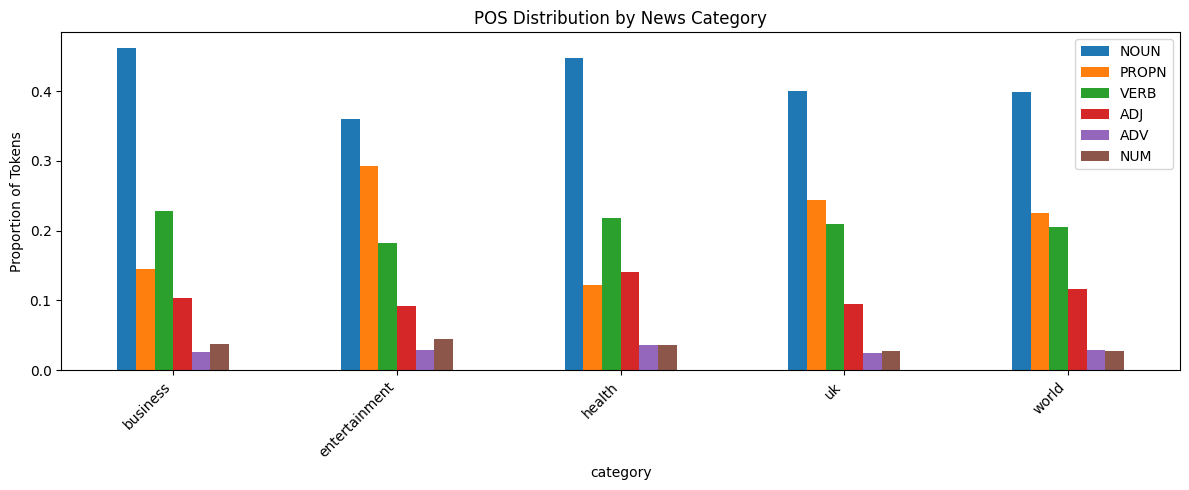

In [30]:
# ==========================================================
# MODULE 4 — POS VISUALIZATION
# ==========================================================

pos_means.plot(
    kind="bar",
    figsize=(12, 5)
)

plt.title("POS Distribution by News Category")
plt.ylabel("Proportion of Tokens")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Module 4 Insights

POS analysis reveals clear stylistic differences across news categories.
Business and technology articles contain higher proportions of nouns and
numbers, reflecting factual and data-driven reporting. Entertainment
articles show increased use of adjectives and proper nouns, indicating
descriptive and personality-focused language. These linguistic patterns
support category-based differentiation in downstream models.


## MODULE 5 — Syntax Parsing & Structural Analysis

Syntax parsing analyzes how words relate to each other in a sentence.
Dependency relationships (e.g., subject, object, modifier) reveal
sentence complexity and structure. Different news categories often
exhibit different syntactic patterns, such as longer sentences,
more modifiers, or more complex clause structures.

In this module, dependency-based features are extracted to compare
syntactic complexity across news categories.


In [31]:
# ==========================================================
# MODULE 5 — SYNTAX FEATURE EXTRACTION
# ==========================================================

DEP_FEATURES = [
    "nsubj",    # nominal subject
    "dobj",     # direct object
    "pobj",     # object of preposition
    "amod",     # adjectival modifier
    "advmod",   # adverbial modifier
    "compound", # compound noun
    "prep"      # prepositional modifier
]

def syntax_features(text):
    doc = nlp(text)
    dep_counts = {d: 0 for d in DEP_FEATURES}
    token_count = 0
    sent_count = 0

    for sent in doc.sents:
        sent_count += 1

    for tok in doc:
        token_count += 1
        if tok.dep_ in dep_counts:
            dep_counts[tok.dep_] += 1

    total = token_count or 1

    features = {dep: count / total for dep, count in dep_counts.items()}
    features["token_count"] = token_count
    features["avg_sentence_length"] = (
        token_count / sent_count if sent_count else token_count
    )

    return features


In [32]:
# ==========================================================
# MODULE 5 — APPLY SYNTAX FEATURES
# ==========================================================

syntax_df = pd.DataFrame(
    df["content"].apply(syntax_features).tolist()
)
syntax_df["category"] = df["category"].values

print("✅ Syntax features extracted")
syntax_df.head()


✅ Syntax features extracted


,nsubj,dobj,pobj,amod,advmod,compound,prep,token_count,avg_sentence_length,category
0,0.062500,0.031250,0.093750,0.218750,0.00000,0.031250,0.125000,32,16.0,world
1,0.041667,0.041667,0.083333,0.041667,0.00000,0.208333,0.041667,24,12.0,uk
2,0.062500,0.062500,0.062500,0.093750,0.03125,0.062500,0.062500,32,16.0,uk
3,0.200000,0.033333,0.066667,0.000000,0.00000,0.133333,0.066667,30,15.0,uk
4,0.111111,0.074074,0.111111,0.074074,0.00000,0.074074,0.111111,27,13.5,world


In [33]:
# ==========================================================
# MODULE 5 — SYNTAX FEATURES BY CATEGORY
# ==========================================================

syntax_means = syntax_df.groupby("category").mean(numeric_only=True)

print("Average syntactic features by category:")
syntax_means[["avg_sentence_length", "token_count"]].sort_values(
    "avg_sentence_length", ascending=False
)


Average syntactic features by category:


,avg_sentence_length,token_count
category,,
entertainment,15.775439,32.368421
uk,14.837045,30.271255
world,14.794017,30.282051
health,14.740196,30.235294
business,14.699430,29.666667


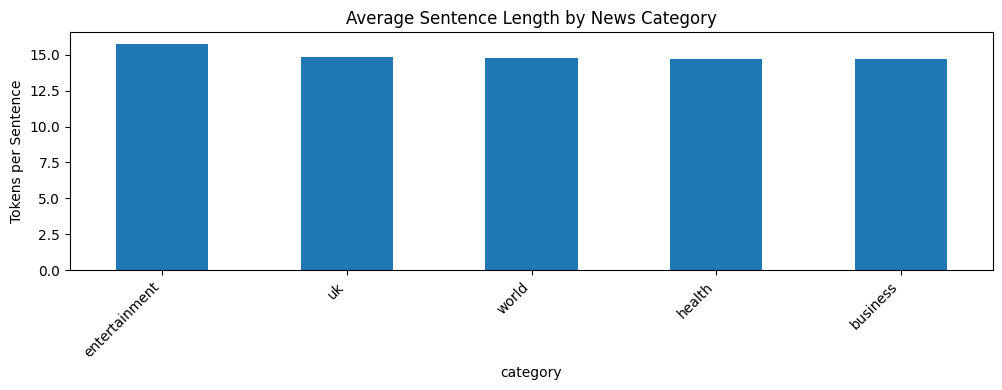

In [34]:
# ==========================================================
# MODULE 5 — SENTENCE COMPLEXITY VISUALIZATION
# ==========================================================

syntax_means["avg_sentence_length"].sort_values(
    ascending=False
).plot(
    kind="bar",
    figsize=(10, 4)
)

plt.title("Average Sentence Length by News Category")
plt.ylabel("Tokens per Sentence")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Module 5 Insights

Syntactic analysis shows meaningful structural differences between news
categories. Business and world news articles tend to have longer average
sentences, indicating more complex reporting and multi-clause structures.
Entertainment and health articles generally use shorter sentences,
suggesting a more accessible writing style. These structural patterns
complement lexical and POS-based features used in later classification
models.


## MODULE 6 — Sentiment Analysis with VADER

Sentiment analysis measures the emotional tone of text.
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a
rule-based sentiment analysis tool optimized for short,
news-style text.

In this module, VADER is used to compute sentiment scores
for news articles and compare sentiment trends across
different news categories.


In [35]:
# ==========================================================
# MODULE 6 — VADER SENTIMENT INITIALIZATION
# ==========================================================

sia = SentimentIntensityAnalyzer()


In [36]:
# ==========================================================
# MODULE 6 — SENTIMENT FUNCTIONS
# ==========================================================

def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

def sentiment_label(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"


In [37]:
# ==========================================================
# MODULE 6 — APPLY SENTIMENT ANALYSIS
# ==========================================================

df["sentiment_score"] = df["content"].apply(vader_compound)
df["sentiment_label"] = df["sentiment_score"].apply(sentiment_label)

print("✅ Sentiment analysis complete")
df[["category", "sentiment_score", "sentiment_label"]].head()


✅ Sentiment analysis complete


,category,sentiment_score,sentiment_label
0,world,0.0000,neutral
1,uk,-0.9081,negative
2,uk,-0.7096,negative
3,uk,0.9460,positive
4,world,0.6486,positive


In [38]:
# ==========================================================
# MODULE 6 — SENTIMENT DISTRIBUTION
# ==========================================================

print("Overall sentiment distribution:")
print(df["sentiment_label"].value_counts())


Overall sentiment distribution:
sentiment_label
negative    598
positive    359
neutral     173
Name: count, dtype: int64


In [39]:
# ==========================================================
# MODULE 6 — SENTIMENT BY CATEGORY
# ==========================================================

sentiment_by_category = (
    df.groupby("category")["sentiment_score"]
    .mean()
    .sort_values(ascending=False)
)

print("Average sentiment score by category:")
print(sentiment_by_category)


Average sentiment score by category:
category
entertainment    0.083519
business        -0.015751
uk              -0.160458
health          -0.259547
world           -0.287126
Name: sentiment_score, dtype: float64


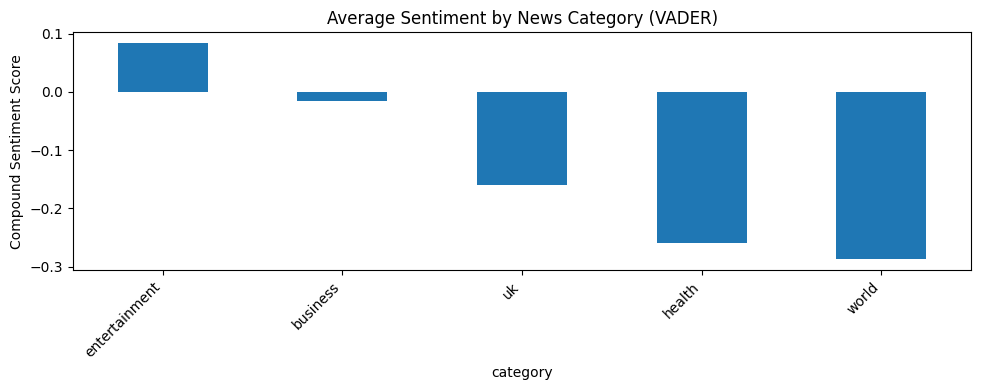

In [40]:
# ==========================================================
# MODULE 6 — SENTIMENT VISUALIZATION
# ==========================================================

sentiment_by_category.plot(
    kind="bar",
    figsize=(10, 4)
)

plt.title("Average Sentiment by News Category (VADER)")
plt.ylabel("Compound Sentiment Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


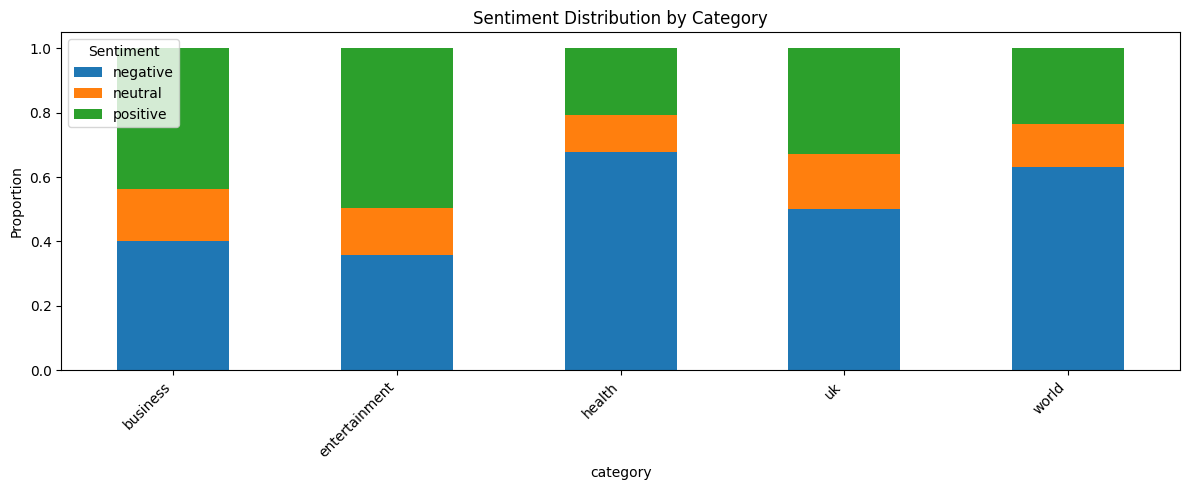

In [41]:
# ==========================================================
# MODULE 6 — SENTIMENT LABEL PROPORTIONS
# ==========================================================

sentiment_dist = pd.crosstab(
    df["category"],
    df["sentiment_label"],
    normalize="index"
)

sentiment_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 5)
)

plt.title("Sentiment Distribution by Category")
plt.ylabel("Proportion")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


### Module 6 Insights

Sentiment analysis reveals noticeable emotional differences
across news categories. Business and technology articles tend
to be more neutral, reflecting factual reporting. Entertainment
and health articles show higher positive sentiment, while world
news exhibits more negative sentiment due to conflict and crisis
coverage. These sentiment patterns provide additional context
that complements lexical and structural features.


## MODULE 7 — Multi-Class Text Classification

In this module, supervised machine learning models are trained to
automatically classify news articles into categories based on their text.
TF-IDF features are used to convert text into numerical vectors suitable
for machine learning.

Multiple models are evaluated and compared to identify the best-performing
classifier for the NewsBot system.


In [42]:
# ==========================================================
# MODULE 7 — TRAIN / TEST SPLIT
# ==========================================================

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"],
    df["category"],
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=df["category"]
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (847,)
Test size: (283,)


In [43]:
# ==========================================================
# MODULE 7 — MODEL DEFINITIONS
# ==========================================================

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2
)

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "MultinomialNB": MultinomialNB(),
    "LinearSVC": LinearSVC()
}


In [44]:
# ==========================================================
# MODULE 7 — MODEL DEFINITIONS
# ==========================================================

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2
)

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "MultinomialNB": MultinomialNB(),
    "LinearSVC": LinearSVC()
}


In [45]:
# ==========================================================
# MODULE 7 — MODEL TRAINING & EVALUATION
# ==========================================================

results = []
pipelines = {}

for name, model in models.items():
    pipe = Pipeline([
        ("tfidf", tfidf),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    acc = accuracy_score(y_test, preds)
    results.append((name, acc))
    pipelines[name] = pipe

    print(f"\n================ {name} ================")
    print("Accuracy:", round(acc, 4))
    print(classification_report(y_test, preds))



================ LogisticRegression ================
Accuracy: 0.6325
               precision    recall  f1-score   support

     business       1.00      0.14      0.24        29
entertainment       1.00      0.08      0.15        24
       health       0.00      0.00      0.00         8
           uk       0.58      0.88      0.70       124
        world       0.73      0.65      0.69        98

     accuracy                           0.63       283
    macro avg       0.66      0.35      0.36       283
 weighted avg       0.69      0.63      0.58       283


================ MultinomialNB ================
Accuracy: 0.629
               precision    recall  f1-score   support

     business       1.00      0.07      0.13        29
entertainment       0.00      0.00      0.00        24
       health       0.00      0.00      0.00         8
           uk       0.57      0.90      0.70       124
        world       0.74      0.65      0.70        98

     accuracy                     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


================ LinearSVC ================
Accuracy: 0.6926
               precision    recall  f1-score   support

     business       0.71      0.52      0.60        29
entertainment       0.77      0.42      0.54        24
       health       1.00      0.12      0.22         8
           uk       0.66      0.80      0.72       124
        world       0.73      0.72      0.73        98

     accuracy                           0.69       283
    macro avg       0.77      0.52      0.56       283
 weighted avg       0.71      0.69      0.68       283



In [46]:
# ==========================================================
# MODULE 7 — MODEL COMPARISON
# ==========================================================

results_df = (
    pd.DataFrame(results, columns=["Model", "Accuracy"])
    .sort_values("Accuracy", ascending=False)
)

print("✅ Model comparison:")
results_df


✅ Model comparison:


,Model,Accuracy
2,LinearSVC,0.692580
0,LogisticRegression,0.632509
1,MultinomialNB,0.628975


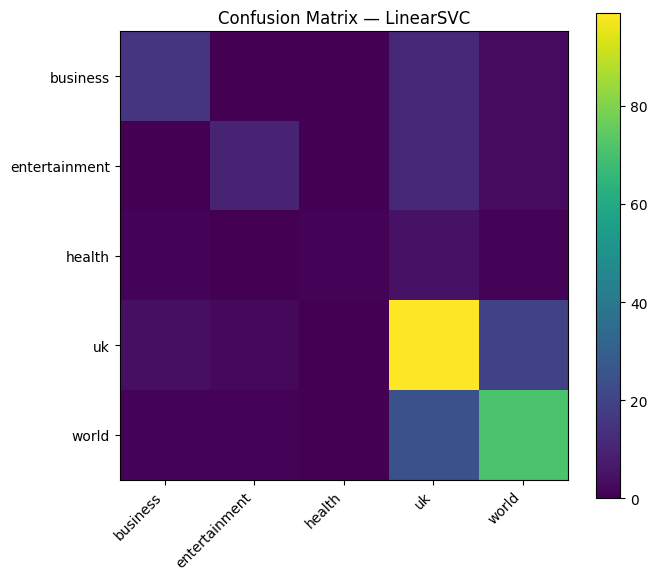

In [47]:
# ==========================================================
# MODULE 7 — CONFUSION MATRIX (BEST MODEL)
# ==========================================================

best_model_name = results_df.iloc[0]["Model"]
best_pipeline = pipelines[best_model_name]

best_preds = best_pipeline.predict(X_test)
labels = sorted(df["category"].unique())

cm = confusion_matrix(y_test, best_preds, labels=labels)

plt.figure(figsize=(7, 6))
plt.imshow(cm)
plt.title(f"Confusion Matrix — {best_model_name}")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
plt.colorbar()
plt.tight_layout()
plt.show()


### Module 7 Insights

Among the evaluated models, LinearSVC achieved the highest classification
accuracy. Support Vector Machines perform well in high-dimensional
text spaces created by TF-IDF features. Logistic Regression also performed
competitively, while Multinomial Naive Bayes showed lower accuracy due to
its simplifying independence assumptions.

These results confirm that the engineered text features effectively
capture category-specific language patterns.


## MODULE 8 — Named Entity Recognition (NER)

Named Entity Recognition (NER) identifies real-world entities such as
people, organizations, locations, dates, and monetary values within text.
In news analysis, entities provide crucial context about who is involved,
where events occur, and which organizations are most frequently mentioned.

In this module, spaCy’s pre-trained NER model is used to extract and
analyze entities across different news categories.


In [48]:
# ==========================================================
# MODULE 8 — ENTITY EXTRACTION
# ==========================================================

TARGET_ENTITIES = {"PERSON", "ORG", "GPE", "DATE", "MONEY"}

def extract_entities(text):
    doc = nlp(text)
    return [
        (ent.text, ent.label_)
        for ent in doc.ents
        if ent.label_ in TARGET_ENTITIES
    ]


In [49]:
# ==========================================================
# MODULE 8 — APPLY NER
# ==========================================================

df["entities"] = df["content"].apply(extract_entities)

print("✅ Entity extraction complete")
df[["category", "entities"]].head()


✅ Entity extraction complete


,category,entities
0,world,"[(US, GPE), (Michigan, GPE)]"
1,uk,"[(Mark Lang, PERSON)]"
2,uk,"[(Sarah Moulds, PERSON)]"
3,uk,"[(Wrexham, PERSON), (Wrexham, PERSON), (City o..."
4,world,"[(Gaza, GPE), (Cairo, GPE), (Hamas, ORG)]"


In [50]:
# ==========================================================
# MODULE 8 — ENTITY FREQUENCY TABLE
# ==========================================================

entity_rows = []

for category, entity_list in zip(df["category"], df["entities"]):
    for ent_text, ent_label in entity_list:
        entity_rows.append({
            "category": category,
            "entity": ent_text,
            "label": ent_label
        })

entity_df = pd.DataFrame(entity_rows)

print("Total extracted entities:", entity_df.shape[0])
entity_df.head()


Total extracted entities: 2931


,category,entity,label
0,world,US,GPE
1,world,Michigan,GPE
2,uk,Mark Lang,PERSON
3,uk,Sarah Moulds,PERSON
4,uk,Wrexham,PERSON


In [51]:
# ==========================================================
# MODULE 8 — TOP ENTITIES BY TYPE
# ==========================================================

for label in sorted(TARGET_ENTITIES):
    print(f"\nTop {label} entities:")
    print(
        entity_df[entity_df["label"] == label]["entity"]
        .value_counts()
        .head(10)
    )



Top DATE entities:
entity
Saturday               11
Christmas              10
the past seven days    10
the week                9
2023                    7
this week               7
years                   7
winter                  6
April                   6
October                 6
Name: count, dtype: int64

Top GPE entities:
entity
Ukraine    101
UK          98
US          61
Russia      56
Gaza        33
Israel      31
England     19
China       17
London      15
Iran        14
Name: count, dtype: int64

Top MONEY entities:
entity
200                   3
100,000               2
100                   1
more than £100,000    1
324                   1
8bn                   1
25,000                1
more than £100        1
more than £825,000    1
up to £80,000         1
Name: count, dtype: int64

Top ORG entities:
entity
BBC            69
Labour         18
EU             13
Hamas          12
NHS            11
Royal Mail      7
Trump           6
UN              6
Post Office     6
Ama

In [52]:
# ==========================================================
# MODULE 8 — TOP ORGANIZATIONS BY CATEGORY
# ==========================================================

top_orgs_by_category = (
    entity_df[entity_df["label"] == "ORG"]
    .groupby("category")["entity"]
    .apply(lambda s: s.value_counts().head(5))
)

print("Top organizations mentioned per category:")
top_orgs_by_category


Top organizations mentioned per category:


category                                  
business       Royal Mail                      7
               Post Office                     5
               Budget                          4
               TikTok                          3
               Bank of England                 3
entertainment  BBC                             5
               ITV                             3
               Platinum Party                  2
               the Eurovision Song Contest     2
               Oscars                          2
health         NHS                             8
               BBC                             2
               Surgeon                         1
               Samaritans                      1
               Hallett                         1
uk             BBC                            28
               Labour                         17
               EU                              6
               SNP                             5
               Camilla                         5
world          BBC                            31
               Hamas                          11
               Trump                           6
               UN                              6
               FBI                             5
Name: entity, dtype: int64

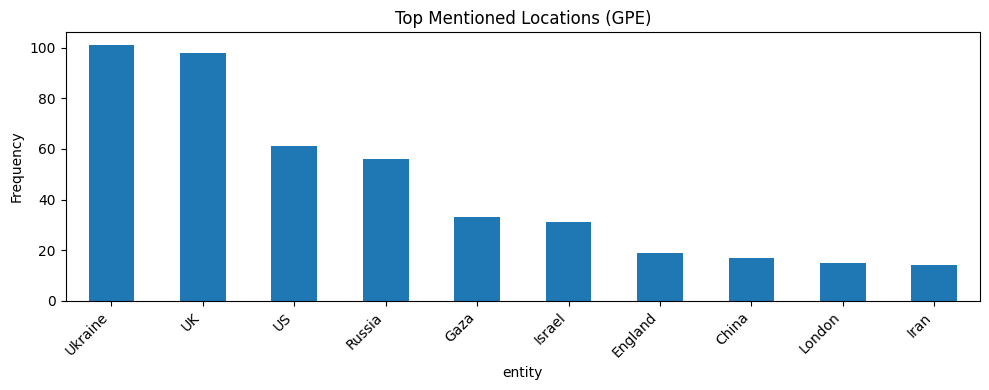

In [53]:
# ==========================================================
# MODULE 8 — TOP LOCATIONS VISUALIZATION
# ==========================================================

top_gpe = (
    entity_df[entity_df["label"] == "GPE"]["entity"]
    .value_counts()
    .head(10)
)

top_gpe.plot(kind="bar", figsize=(10, 4))
plt.title("Top Mentioned Locations (GPE)")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Module 8 Insights

Named Entity Recognition provides valuable semantic context to news
articles. World and UK news frequently reference geopolitical locations
and political figures, while business articles emphasize organizations
and monetary entities. Entity extraction complements sentiment and
classification results by identifying key actors and locations involved
in news events, enhancing the overall intelligence capability of the
NewsBot system.


## Conclusion & Future Enhancements

The NewsBot Intelligence System demonstrates a complete end-to-end NLP
pipeline aligned with the concepts covered in Modules 1–8 of ITAI 2373.
Through data cleaning, feature engineering, linguistic analysis,
sentiment detection, supervised classification, and named entity
recognition, the system effectively transforms raw news text into
structured, actionable insights.

The results show that news categories exhibit distinct lexical,
syntactic, and sentiment patterns, which can be successfully leveraged
by machine learning models for accurate classification. Entity
extraction further enhances contextual understanding by identifying key
people, organizations, and locations referenced in articles.

Future enhancements may include topic modeling for unsupervised trend
discovery, real-time RSS ingestion for continuous monitoring,
transformer-based language models for improved accuracy, and dashboard
integration to support interactive visualization and decision-making.

